# Plotting Transect Data

This notebook demonstrates some ways to plot transect data, i.e. 2D datasets with a vertical dimension and one horizontal dimension.

The primary method is `plot_utils.transect_tricontourf()`, which accepts data in several forms of an `xarray.DataArray`.

(xarray is the offspring of `numpy` and `pandas`, roughly equivalent to a nice interface to netcdf files.)

In [24]:
# plotting routines
import matplotlib.pyplot as plt
from stompy.plot import plot_utils 
from stompy.plot.cmap import load_gradient

import xarray as xr # data structure
import numpy as np  

cmap=load_gradient('cbcSpectral.cpt')

%matplotlib inline

## Data on a (unevenly spaced) grid: $c = f(x_i,z_j)$

When $c$ is defined for all points on the grid

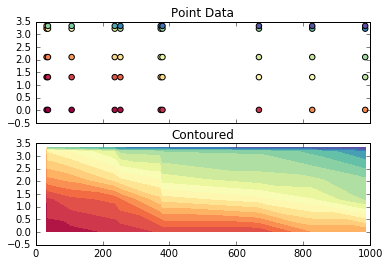

In [35]:
# Fabricate a dataset:
x=np.sort(1000*np.random.random(10))
z=np.sort(5*np.random.random(5))
scalar=np.random.random( (len(x),len(z)) )
scalar.sort(axis=1)
scalar.sort(axis=0)
# Package into data array
transect_data = xr.DataArray(scalar,
                             coords=[ ('x',x),
                                      ('z',z)])

fig,axs=plt.subplots(2,1,sharex=True,sharey=True)

Y,X = np.meshgrid(transect_data.z,transect_data.x)
axs[0].scatter(X,Y,30,scalar,cmap=cmap)
axs[0].set_title('Point Data')

coll=plot_utils.transect_tricontourf(transect_data,ax=axs[1],V=20,
                                     cmap=cmap,
                                     xcoord='x',
                                     ycoord='z')
axs[1].set_title('Contoured') ;

## Partial data on a (unevenly spaced) grid: $c = f(x_i,z_j)$

When $c$ is np.nan for some $(x_i,z_j)$.

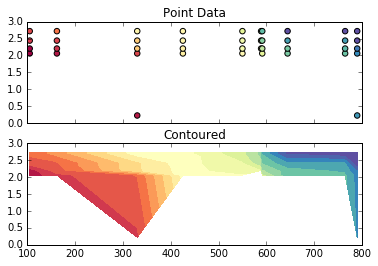

In [37]:
# Have to specify the limits of the contours now.

# fabricate unevenly spaced, monotonic x,z variables
x=np.sort(1000*np.random.random(10))
z=np.sort(5*np.random.random(5))
scalar=np.random.random( (len(x),len(z)) )
scalar.sort(axis=0) ; scalar.sort(axis=1)
# Randomly drop about 20% of the bottom of each profile
mask = np.sort(np.random.random( (10,5) ),axis=1) < 0.2
scalar[mask]=np.nan
# also supports masked array:
# scalar=np.ma.masked_array(scalar,mask=mask)

# Same layout for the DataArray, but now scalar is missing some data.
transect_data = xr.DataArray(scalar,
                             coords=[ ('x',x),
                                      ('z',z)])

fig,axs=plt.subplots(2,1,sharex=True,sharey=True)

Y,X = np.meshgrid(transect_data.z,transect_data.x)
axs[0].scatter(X,Y,30,scalar,cmap=cmap)
axs[0].set_title('Point Data')

coll=plot_utils.transect_tricontourf(transect_data,ax=axs[1],V=np.linspace(0,1,20),
                                     cmap=cmap,
                                     xcoord='x',
                                     ycoord='z')
axs[1].set_title('Contoured') ;

## Per-profile vertical coordinate: $c = f(x_i,z_{(i,j)})$

In other words, data is composed of profiles and each profile has a constant
$x$ but its own $z$ coordinate.

This example also shows how `Dataset`s can be used to organize multiple variables,
and how pulling out a variable into a `DataArray` brings the coordinate variablyes
along with it.

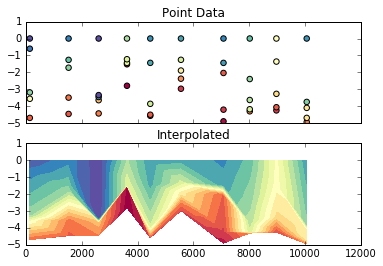

In [64]:
# fabricate unevenly spaced, monotonic x variable
x=np.linspace(0,10000,10)  + 500*np.random.random(10)
# vertical coordinate is now a 2D variable, ~ (profile,sample)
cast_z=np.sort(-5*np.random.random((10,5)),axis=1)
cast_z[:,-1]=0
scalar=np.sort( np.random.random( cast_z.shape),axis=1)

ds=xr.Dataset()
ds['x']=('x',x)
ds['cast_z']=( ('x','z'),cast_z)
ds['scalar']=( ('x','z'), scalar )
ds=ds.set_coords( ['x','cast_z'])
transect_data = ds['scalar']

fig,axs=plt.subplots(2,1,sharex=True,sharey=True)

Y=transect_data.cast_z
X=np.ones_like(transect_data.cast_z) * transect_data.x.values[:,None]

axs[0].scatter(X,Y,30,scalar,cmap=cmap)
axs[0].set_title('Point Data')

coll=plot_utils.transect_tricontourf(transect_data,ax=axs[1],V=np.linspace(0,1,20),
                                     cmap=cmap,
                                     xcoord='x',
                                     ycoord='cast_z')
axs[1].set_title('Interpolated') ;

## High-order interpolation

Same data "shape" as above, but when the data are sufficiently well-behaved,
it is possible to use a high-order interpolation.

This is also introduces access to the underlying triangulation object, for more 
detailed plotting and interpolation.

The plot shows the smoothed, interpolated field, as well as the original triangulation
and the refined triangulation.

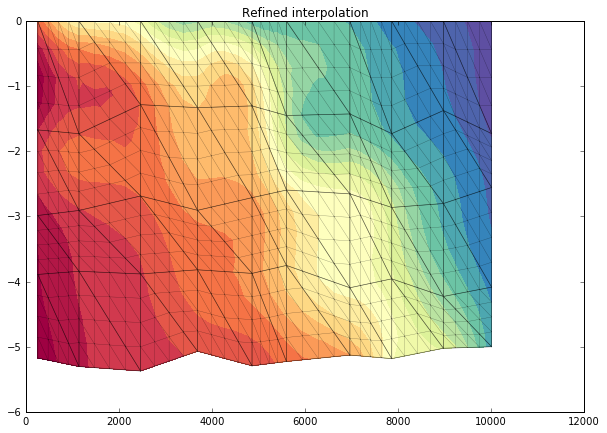

In [81]:
import matplotlib.tri as mtri

# fabricate unevenly spaced, monotonic x variable
# Make the points more evenly spaced to 
x=np.linspace(0,10000,10)  + 500*np.random.random(10)
# vertical coordinate is now a 2D variable, ~ (cast,sample)
cast_z=np.linspace(0,1,5)[None,:] + 0.1*np.random.random((10,5))
cast_z=np.sort(-5*cast_z,axis=1)
cast_z[:,-1]=0
scalar=np.sort(np.sort(np.random.random( cast_z.shape),axis=0),axis=1)

ds=xr.Dataset()
ds['x']=('x',x)
ds['cast_z']=( ('x','z'),cast_z)
ds['scalar']=( ('x','z'), scalar )
ds=ds.set_coords( ['x','cast_z'])
transect_data = ds['scalar']

fig,ax=plt.subplots(figsize=(10,7))

tri,mapper=plot_utils.transect_to_triangles(transect_data,xcoord='x',ycoord='cast_z')


# This only works with relatively smooth data!
refiner = mtri.UniformTriRefiner(tri)
tri_refi, z_refi = refiner.refine_field(mapper(transect_data.values), subdiv=2)
plt.tricontourf(tri_refi, z_refi, 
                levels=np.linspace(0,1,20), cmap=cmap)

# Show how the interpolation is constructed:
ax.triplot(tri_refi,color='k',lw=0.3,alpha=0.5)
ax.triplot(tri,color='k',lw=0.7,alpha=0.5)

ax.set_title('Refined interpolation') ;